In [1]:
import os.path

from tqdm.notebook import tqdm

from metplot import *
from modules.datetime import DateTime, dayofyear_to_date
import modules.era5.dataset as era5

from matplotlib.animation import FuncAnimation


In [2]:
cmaps = {"temperature": matplotlib.colors.LinearSegmentedColormap.from_list(
    "Temperature", ["#d7e4fc", "#5fb1d4", "#4e9bc8", "#466ae1", "#6b1966", "#952c5e", "#d12d3e", "#fa7532", "#f5d25f"]),
    "u_component_of_wind": cmr.ocean,
    "v_component_of_wind": cmr.ocean,
    "wind_direction": "twilight",
    "wind_speed": cmr.ocean,
    "vertical_velocity": "RdBu"
}

vlims_1000hPa = {
    "temperature": (-40, 40),
    "u_component_of_wind": (-15, 15),
    "v_component_of_wind": (-15, 15),
    "wind_direction": (-180, 180),
    "wind_speed": (0, 16),
    "vertical_velocity": (-1.5, 1.5)
}

In [3]:
def plot_latlon_contour(variable: str, datetime, level, **kwargs):
    data = era5.get_latlon_contour_data(variable, datetime, level)

    plot = ImagePlot(data, f"{format_variable(variable)} {format_time(datetime)} {format_pressure(level)}",
                     cmap=cmaps.get(variable, cmr.ocean), **kwargs)
    plot.plot()
    plot.show()

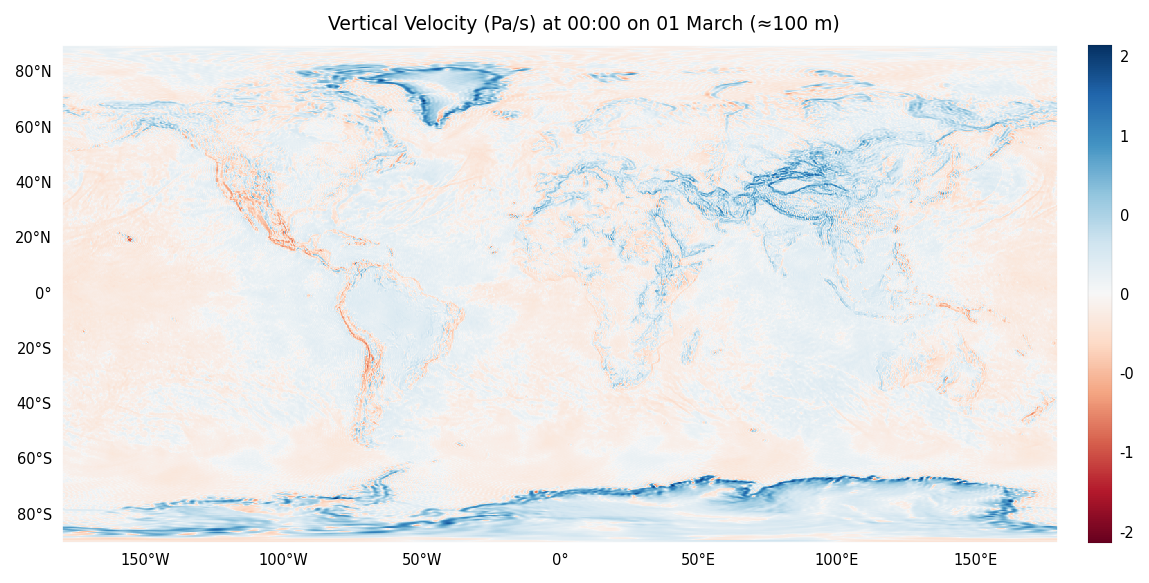

In [4]:
%matplotlib inline

plot_latlon_contour("vertical_velocity", DateTime(month=3, day=1, hour=0, year="tavg"), level=1000, diverging=True, 
                    interpolation="nearest")

In [5]:
import os


def animate_latlon_contour_vs_time(variable: str, level, **kwargs):
    output = f"../generated/contours/animated/ERA5-{variable}-tavg-0101-1231-lev{level}.mp4"
    if os.path.isfile(output):
        return

    datetime = DateTime(month=1, day=1, hour=0, year="tavg")
    d = era5.get_latlon_contour_data(variable, datetime, level)

    if level == 1000:
        kwargs["vmin"] = vlims_1000hPa[variable][0]
        kwargs["vmax"] = vlims_1000hPa[variable][1]

    plot = ImagePlot(d, cmap=cmaps[variable], **kwargs)
    plot.plot()

    def update(i):
        day, month = dayofyear_to_date(i // 24)
        dt = DateTime(month=month, day=day, hour=i % 24, year="tavg")

        data = era5.get_latlon_contour_data(variable, dt, level)
        plot.title = f"{format_variable(variable)} {format_time(dt)} {format_pressure(level)}"
        return [plot.update_data(data)]

    anim = FuncAnimation(plot.fig, update, frames=tqdm(tuple(range(24 * 365))), blit=True, interval=0)
    anim.save(output, fps=30, writer="ffmpeg")

  0%|          | 0/8760 [00:00<?, ?it/s]

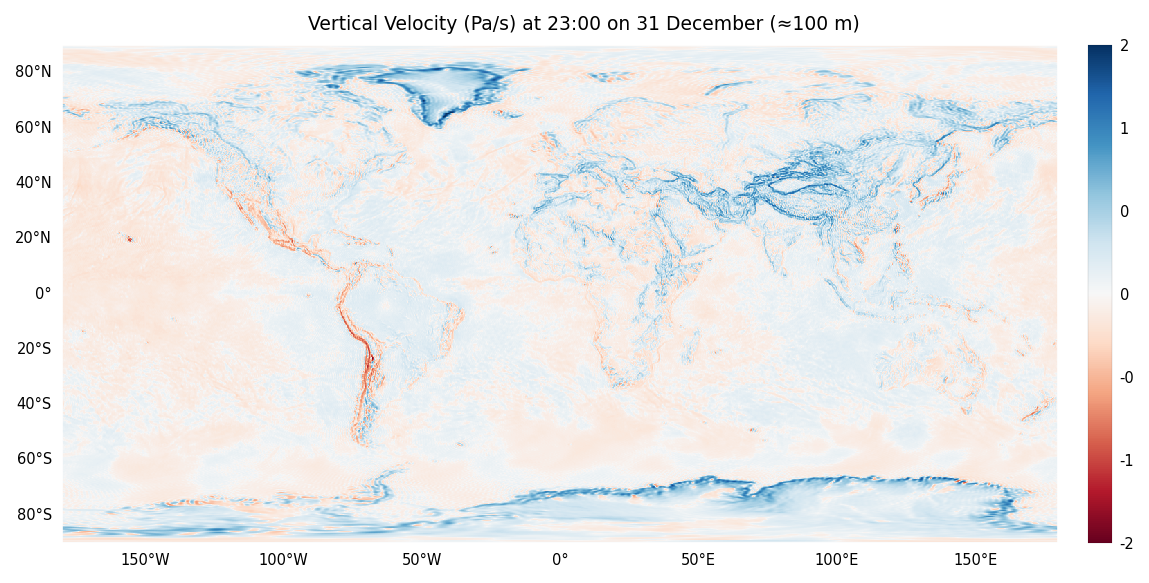

In [14]:
animate_latlon_contour_vs_time("vertical_velocity", level=1000, interpolation="nearest")

In [ ]:
animate_latlon_contour_vs_time("temperature", level=150, vmin=-70, vmax=-40)

In [ ]:
animate_latlon_contour_vs_time("u_component_of_wind", level=150, vmin=-40, vmax=70)

  0%|          | 0/8760 [00:00<?, ?it/s]

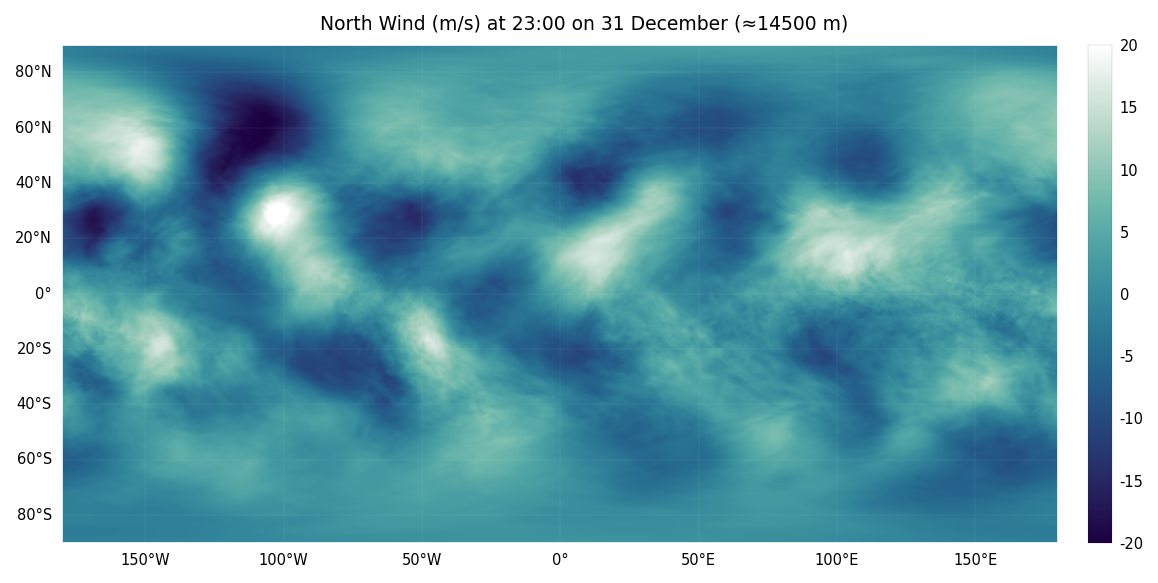

In [28]:
animate_latlon_contour_vs_time("v_component_of_wind", level=150, vmin=-20, vmax=20)

In [12]:
animate_latlon_contour_vs_time("wind_direction", level=150, vmin=-180, vmax=180, interpolation="nearest")

  0%|          | 0/8760 [00:00<?, ?it/s]

In [9]:
def animate_latlon_contour_vs_level(variable: str, datetime, **kwargs):
    data = era5.get_latlon_contour_data(variable, datetime)
    levels = era5.open_dataset(datetime)["level"].values

    plot = ImagePlot(data[0], cmap=cmaps[variable], **kwargs)
    plot.plot()

    def update(i):
        plot.title = f"{format_variable(variable)} {format_time(datetime)} {format_pressure(levels[i])}"
        return [plot.update_data(data[i])]

    anim = FuncAnimation(plot.fig, update, frames=tqdm(tuple(range(len(levels)))), blit=True, interval=0)
    anim.save(f"../generated/contours/animated/ERA5-{variable}-{datetime}.mp4", fps=15, writer="ffmpeg")

In [ ]:
animate_latlon_contour_vs_level("u_component_of_wind", DateTime(month=6, day=1, hour=0, year="tavg"), diverging=False)
